# Product Quantization Walkthrough

This notebook walks through Product Quantization (PQ) step by step.

**PQ (Jegou et al., 2011):** Split D-dimensional vectors into M subspaces, learn a k-means codebook per subspace (k=256), and encode each subvector as a 1-byte centroid index. Distance computation uses Asymmetric Distance Computation (ADC) lookup tables.

**Key properties:**
- Compression: D×4 bytes → M bytes
- Biased distance estimator (no theoretical error bound)
- Hyperparameters: M (number of subspaces), Ks (centroids per subspace)

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
rng = np.random.default_rng(42)

## 1. Generate Synthetic Data

We'll use synthetic data to clearly see PQ's behavior before moving to real datasets.

In [2]:
D = 32  # dimension
n_train = 5000
n_db = 2000
n_queries = 50

X_train = rng.standard_normal((n_train, D)).astype(np.float32)
X_db = X_train[:n_db]
X_queries = rng.standard_normal((n_queries, D)).astype(np.float32)

print(f'Training data: {X_train.shape}')
print(f'Database: {X_db.shape}')
print(f'Queries: {X_queries.shape}')

Training data: (5000, 32)
Database: (2000, 32)
Queries: (50, 32)


## 2. How PQ Splits Vectors into Subspaces

PQ divides each D-dimensional vector into M equal-length subvectors.

D=32, M=4, Ds=8
Each 32-dim vector is split into 4 subvectors of 8 dimensions each


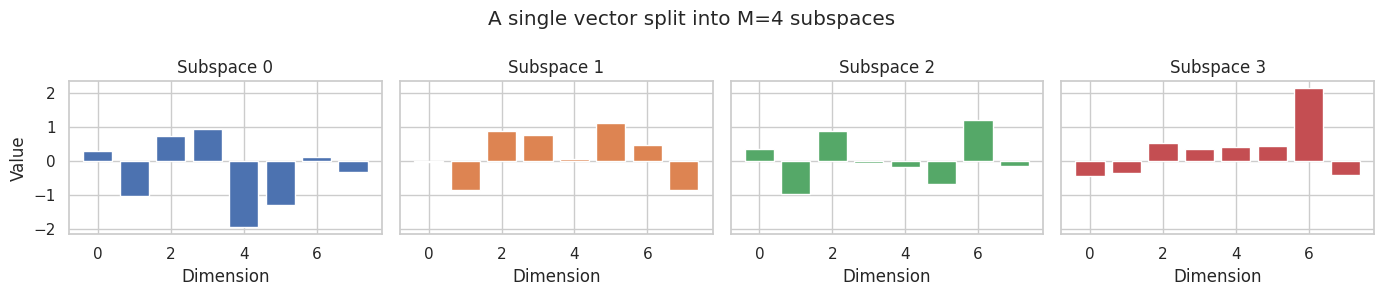

In [3]:
M = 4  # number of subspaces
Ds = D // M  # sub-dimension

print(f'D={D}, M={M}, Ds={Ds}')
print(f'Each {D}-dim vector is split into {M} subvectors of {Ds} dimensions each')

# Visualize the splitting
fig, axes = plt.subplots(1, M, figsize=(14, 3), sharey=True)
vec = X_train[0]
for m in range(M):
    sub = vec[m*Ds:(m+1)*Ds]
    axes[m].bar(range(Ds), sub, color=f'C{m}')
    axes[m].set_title(f'Subspace {m}')
    axes[m].set_xlabel('Dimension')
axes[0].set_ylabel('Value')
plt.suptitle('A single vector split into M=4 subspaces')
plt.tight_layout()

## 3. K-Means Training per Subspace

For each subspace, PQ runs k-means to learn Ks centroids.

In [4]:
from src.quantizers.pq import ProductQuantizer

Ks = 256
pq = ProductQuantizer(M=M, Ks=Ks)
pq.fit(X_train)

print(f'Codebook shape: {pq.codebooks.shape}')  # (M, Ks, Ds)
print(f'Each subspace has {Ks} centroids of dimension {Ds}')
print(f'Total codebook memory: {pq.codebooks.nbytes / 1024:.1f} KB')

Codebook shape: (4, 256, 8)
Each subspace has 256 centroids of dimension 8
Total codebook memory: 32.0 KB


## 4. Encoding: Assign Subvectors to Centroids

Each subvector is replaced by its nearest centroid index (0-255), giving a 1-byte code per subspace.

In [5]:
codes = pq.encode(X_db)
print(f'Codes shape: {codes.shape}, dtype: {codes.dtype}')
print(f'\nFirst 5 vectors\' codes:\n{codes[:5]}')
print(f'\nCompression: {X_db.nbytes / 1024:.1f} KB -> {codes.nbytes / 1024:.1f} KB')
print(f'Compression ratio: {X_db.nbytes / codes.nbytes:.1f}x')

Codes shape: (2000, 4), dtype: uint8

First 5 vectors' codes:
[[237  40 125  70]
 [ 11  42  37  66]
 [208 221 253 111]
 [ 58 244 163 127]
 [142 170 116  31]]

Compression: 250.0 KB -> 7.8 KB
Compression ratio: 32.0x


## 5. Reconstruction Error

Decoding reconstructs vectors by replacing each code with the corresponding centroid.

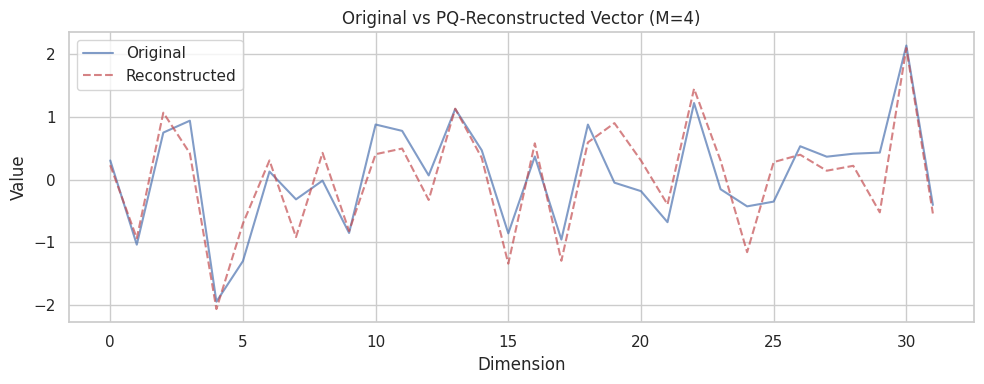

In [6]:
X_hat = pq.decode(codes)

# Compare original vs reconstructed for a single vector
idx = 0
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(X_db[idx], 'b-', label='Original', alpha=0.7)
ax.plot(X_hat[idx], 'r--', label='Reconstructed', alpha=0.7)
ax.set_xlabel('Dimension')
ax.set_ylabel('Value')
ax.set_title(f'Original vs PQ-Reconstructed Vector (M={M})')
ax.legend()
plt.tight_layout()

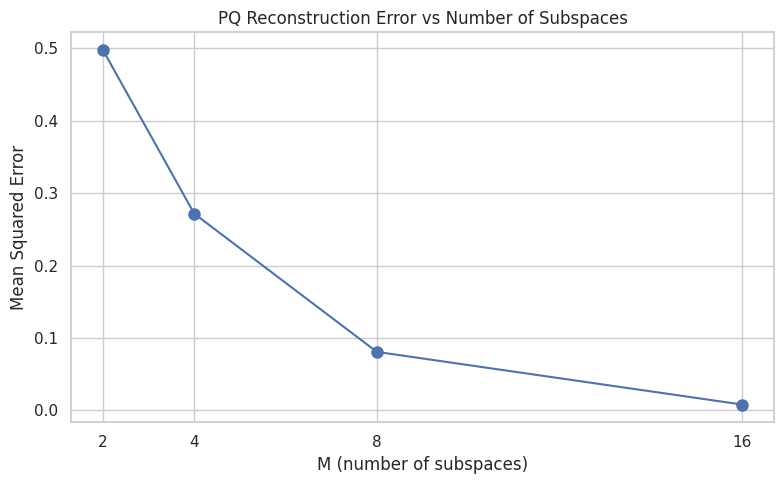

In [7]:
# Reconstruction error vs M
ms = [2, 4, 8, 16]
mses = []
for m in ms:
    pq_m = ProductQuantizer(M=m, Ks=256)
    pq_m.fit(X_train)
    codes_m = pq_m.encode(X_db)
    hat_m = pq_m.decode(codes_m)
    mses.append(np.mean((X_db - hat_m) ** 2))

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(ms, mses, 'o-', markersize=8)
ax.set_xlabel('M (number of subspaces)')
ax.set_ylabel('Mean Squared Error')
ax.set_title('PQ Reconstruction Error vs Number of Subspaces')
ax.set_xticks(ms)
plt.tight_layout()

## 6. Asymmetric Distance Computation (ADC)

Instead of comparing query to reconstructed vectors, PQ pre-computes a distance lookup table.

For each subspace m and centroid k: `table[m, k] = ||q_m - c_{m,k}||^2`

Then: `d(q, x) ≈ sum_m table[m, code_m(x)]`

Distance table shape: (4, 256)


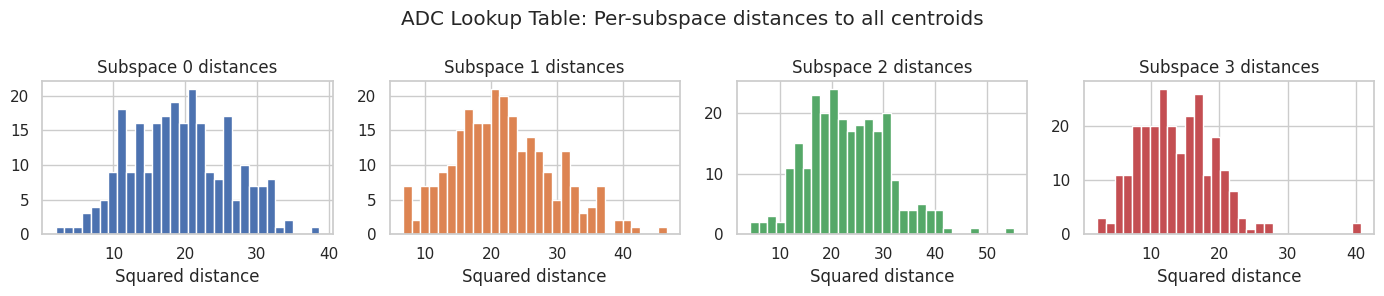

In [8]:
pq.build_database(X_db)

# Build distance table for one query
q = X_queries[0]
table = pq._build_distance_table(q)
print(f'Distance table shape: {table.shape}')  # (M, Ks)

# Visualize the table
fig, axes = plt.subplots(1, M, figsize=(14, 3))
for m in range(M):
    axes[m].hist(table[m], bins=30, color=f'C{m}')
    axes[m].set_title(f'Subspace {m} distances')
    axes[m].set_xlabel('Squared distance')
plt.suptitle('ADC Lookup Table: Per-subspace distances to all centroids')
plt.tight_layout()

## 7. Search Quality: Recall@k

M= 2: recall@10 = 0.138
M= 4: recall@10 = 0.326
M= 8: recall@10 = 0.630
M=16: recall@10 = 0.878


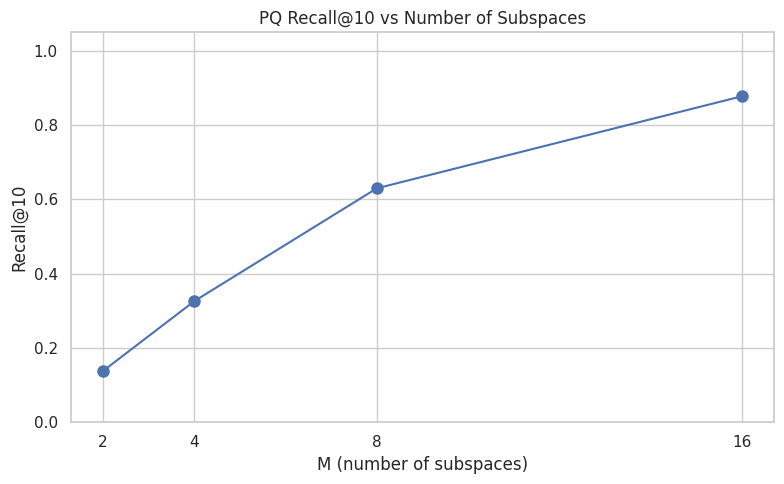

In [9]:
from src.search.exhaustive import exhaustive_search
from src.evaluation.metrics import recall_at_k

k = 10
true_idx, true_dist = exhaustive_search(X_queries, X_db, k=k)

recalls = {}
for m in [2, 4, 8, 16]:
    pq_m = ProductQuantizer(M=m, Ks=256)
    pq_m.fit(X_train)
    pq_m.build_database(X_db)
    pred_idx, _ = pq_m.search(X_queries, k=k)
    recalls[m] = recall_at_k(pred_idx, true_idx, k=k)
    print(f'M={m:2d}: recall@{k} = {recalls[m]:.3f}')

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(recalls.keys()), list(recalls.values()), 'o-', markersize=8)
ax.set_xlabel('M (number of subspaces)')
ax.set_ylabel(f'Recall@{k}')
ax.set_title(f'PQ Recall@{k} vs Number of Subspaces')
ax.set_xticks(list(recalls.keys()))
ax.set_ylim(0, 1.05)
plt.tight_layout()